#### Pakkar

In [1]:
# Our Libraries 
from ourModules import text_processor
from ourModules import toxic_comment_Classifier

/Users/numisteinn/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [1]:
# Libraries ---------------------------------
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction import stop_words
import string
from tensorflow.python.keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Dropout
from tensorflow.python.keras.optimizers import Adadelta
import scipy.sparse
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sn

from itertools import cycle

from sklearn.metrics import roc_curve, auc
from scipy import interp

from matplotlib.colors import Normalize
import warnings; 
# # %tensorflow_version 1.x
# import tensorflow
# print(tensorflow.__version__)
import tensorflow as tf

/Users/numisteinn/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
tf.compat.v1.disable_eager_execution()

#### Innlestur gagna

In [3]:
train_data = pd.read_csv('data/train.csv',delimiter=',')
train_data.drop('id',axis=1,inplace=True) # Id er gagnslaust til ad spa
# test_labeled_data = pd.read_csv('data/test_labels.csv',delimiter=',') # Will most likely not be used

test_data_big = pd.read_csv('data/test_labels.csv',delimiter=',')
cols = list(train_data)
class_names = cols[1:]


In [40]:
print(display(test_data_big.sample(6)))

# Notum þetta til að prufa lokaniðurstöður
X_test_data_big = train_data.drop(columns = cols[1:])
y_test_data_big = train_data.drop(columns = cols[:1])
print(X_test_data_big.shape)
print(y_test_data_big.shape)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
90979,97b047dd7256b198,-1,-1,-1,-1,-1,-1
14681,18a5d16a928ae25a,0,0,0,0,0,0
37821,3ec39bb29b9a037d,1,0,0,0,0,0
134046,e00da4be2269b517,0,0,0,0,0,0
113066,bcb8616a1e83c321,-1,-1,-1,-1,-1,-1
144341,f132f8daa8cab113,0,0,0,0,0,0


None
(159571, 1)
(159571, 6)


### Gagnasettið
Hér má sjá gagnasettið sem við þjálfum módelið á. Við erum með comment_text og hann er búið að greina (0 eða 1) hvort hann sé toxic, severe_toxic, obscene, threat, insult eða identity_hate.

In [5]:
# Nota þetta til að testa loka módelið
X_train_data = train_data.drop(columns = cols[1:])
y_train_data = train_data.drop(columns = cols[:1])

# 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=12)
X_train_np, X_test_np, y_train_np, y_test_np = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()


In [185]:
print("Shape of training set", X_train_np.shape)
print("Shape of test set", X_test_np.shape)
print(display(train_data.sample(6)))

Shape of training set (127656, 1)
Shape of test set (31915, 1)


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
71960,Well when your ally's block of me is over I wi...,0,0,0,0,0,0
86039,"Chola dynasty peer review \n\nHi, Thanks for y...",0,0,0,0,0,0
90784,"""\n\n Discrete Green's theorem and Antiderivat...",0,0,0,0,0,0
11187,Requested move \n\nPhun (2D Physics Sandbox) →...,0,0,0,0,0,0
36578,"""\n\nQuestion\nIf """"Stepped On My J's"""" isn't ...",0,0,0,0,0,0
80755,You are as empty-headed a Wikipedian as I have...,1,0,0,0,0,0


None


Sjáum frá grafinu og greinilegt er að klasarnir eru nálægt hvor öðrum

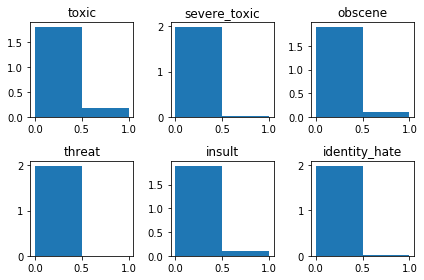

Number of instances marked with toxic: 	 12143/127656 or 9.51%
Number of instances marked with severe_toxic: 	 1265/127656 or 0.99%
Number of instances marked with obscene: 	 6714/127656 or 5.26%
Number of instances marked with threat: 	 387/127656 or 0.30%
Number of instances marked with insult: 	 6275/127656 or 4.92%
Number of instances marked with identity_hate: 	 1117/127656 or 0.88%


In [7]:
# Visualize distribution of y
n_bins = 2
fig, axes = plt.subplots(nrows=2, ncols=3)
axs = axes.flatten()
i = 0
for col in cols[1:]:
    axs[i].hist(y_train[col], n_bins, density=True, histtype='bar')
    axs[i].set_title(col)
    i +=1
fig.tight_layout()
plt.show()
# Notice skewed dataset
for col in cols[1:]:
    cnt = np.count_nonzero(y_train[col])
    print('Number of instances marked with {}: \t {}/{} or {:.2%}'.format(col, cnt,
                                                                    y_train_np.shape[0], cnt/y_train_np.shape[0]) )

In [8]:
def get_row_accuracy(y_true, y_pred):
    acc = np.sum(y_true == y_pred, axis = 1)
    return np.average(np.where(acc == 6, 1, 0), axis = 0)

n,m = y_train_np.shape
y_pred_mat = np.zeros((n,m))

rowindx, colindx = np.nonzero(y_train_np)
rwi = np.unique(rowindx)
# print('Number of rows with at least one none-zero value ', len(rwi))
# non_zero_y_train = y_train_np[rwi]
# # for i in range(m):
# #     print('All-zero guess accuracy on data for {} is: {:.2%}'.format(cols[i+1], np.average(y_pred == y_train_np[:, i])))
# #     print('All-zero guess accuracy for {} but all-zero-rows removed is: {:.2%}'.format(cols[i+1],
# #                                                                 np.average(y_pred[rwi] == non_zero_y_train[:, i])))
# #     print('-'*100)

print('All-zero guess row accuracy on data is: {:.2%}'.format(get_row_accuracy(y_train_np, y_pred_mat)))
mat = confusion_matrix(y_train_np.ravel(), y_pred_mat.ravel())
fpr, tpr, _ = roc_curve(y_train_np.ravel(), y_pred_mat.ravel())
roc_auc = auc(fpr, tpr)
print(roc_auc)

All-zero guess row accuracy on data is: 89.89%
0.5


In [9]:
def plot_roc_curve(y_true_, y_score_, n_classes = 6, show_all_classes = False, model_name = ''):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_[:, i], y_score_[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_.ravel(), y_score_.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    if(show_all_classes):
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'crimson', 'indigo', 'limegreen'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=1,
                     label='ROC curve of {} (area = {:0.2f})'
                     ''.format(cols[i+1], roc_auc[i]))
    plt.grid(None) 
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve of {} model'.format(model_name))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    

In [10]:
def plot_conf_mat(mat, cmap_="OrRd" ):
    tn, fp, fn, tp  = mat.ravel()
    print('-'*50)
    print("TN: {}\t FP: {} \nFN: {}\t TP: {}".format(tn, fp, fn, tp))
    print("The micro averaged sensitivity/recall is: {:.2%}".format(tp/(tp+fn)))
    print("The micro averaged specificity is: {:.2%}".format(tn/(tn+fp)))
    print("The micro averaged precision is: {:.2%}".format(tp/(tp+fp)))
    print('-'*50)
    ax = sn.heatmap(mat, annot=True, fmt="d", cmap=cmap_)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    # Lætur tölurnar vera í miðjum kassanum
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()
    
def calc_scores(y_true_, y_pred_):
    mats = multilabel_confusion_matrix(y_true_, y_pred_)
    n = len(mats)
    recall = 0; specificity = 0; precision = 0
    for mat in mats:
        tn, fp, fn, tp  = mat.ravel()
        recall += tp/(tp+fn)
        specificity += tn/(tn+fp)
        precision += tp/(tp+fp)
        
    print('-'*50)
    print("The macro averaged sensitivity/recall is: {:.2%}".format(recall/n))
    print("The macro averaged specificity is: {:.2%}".format(specificity/n))
    print("The macro averaged precision is: {:.2%}".format(precision/n))
    print('-'*50)



def vectorize_data(X_train_):
    vectorizer = CountVectorizer( max_df=0.95, min_df=10, max_features = None, stop_words='english')
    tfidf_transformer = TfidfTransformer()
    X_train_counts = vectorizer.fit_transform(X_train_.ravel())
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    return X_train_tfidf, vectorizer

# subsamples the data but makes sure all y columns include 2 classes
def data_subsample_asserts_two_classes(X, y, n):
    # Select a random subset of the training data
    max_tries = 15
    tries = 0
    while tries < max_tries:
        perm = np.random.permutation(len(y))
        X_sub=X[perm[0:n],:]
        y_sub=y[perm[0:n]]
        count = 0
        length = y_sub.shape[1]
        for i in range(length):
            # Make sure all columns have 2 classes
            if len(np.unique(y_sub[:,i])) < 2:
                break
            if i == (length-1):
                print('Data subsampling succsessful!')
                return X_sub, y_sub
        tries += 1
#         print("Data subsampling failed in {} try. Trying again.".format(tries) )
#         print('-'*100)
    print("Data subsampling failed in {} tries".format(max_tries))
    return 0,0

def plot_acc_params(param, train_acc_, val_acc_, param_name, title):
    plt.plot(param, val_acc_,label='Validation AUC')
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel('AUC')
    plt.legend()
    plt.show()


# Utility function to move the midpoint of a colormap to be around
# the values of interest.
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def plot_heatmap(data_matrix, title, xlabel, ylabel, x_values, y_values, vmin_, midpoint_):
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(data_matrix, interpolation='nearest', cmap=plt.cm.seismic,
               norm=MidpointNormalize(vmin=vmin_, midpoint=midpoint_))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    
#     plt.grid(None)
    plt.xticks(np.arange(len(x_values)), x_values, rotation=45)
    plt.yticks(np.arange(len(y_values)), y_values)
    plt.title(title)
    plt.show()

Data subsampling succsessful!
Reducing dimensions...
Plotting PCA projection...


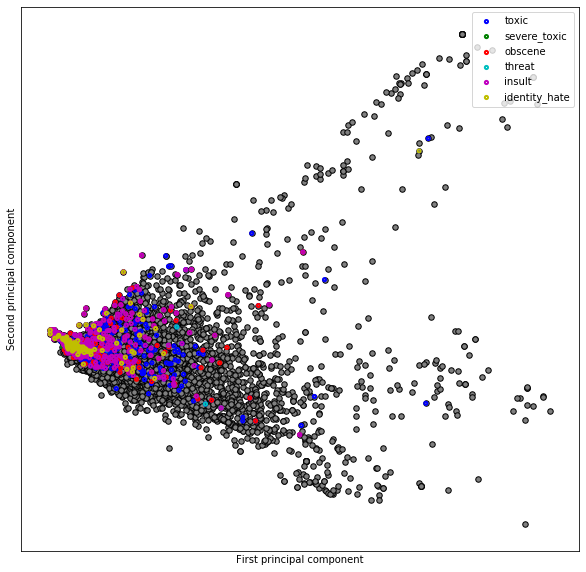

CPU times: user 5.67 s, sys: 968 ms, total: 6.64 s
Wall time: 2.19 s


In [11]:
%%time
def plot_pca(x_data, y_data, colum_names):
    # PCA reynir að halda punktum langt fra hvor öðrum langt frá hvor öðrum
    print("Reducing dimensions...")
    x_2d = PCA(n_components=2).fit_transform(x_data.todense())

    print("Plotting PCA projection...")
    min_x = np.min(x_2d[:, 0])
    max_x = np.max(x_2d[:, 0])

    min_y = np.min(x_2d[:, 1])
    max_y = np.max(x_2d[:, 1])

    colors_ = ['b', 'g', 'r', 'c', 'm', 'y']
    plt.figure(figsize=(10, 10))
    #plots all the dots
    plt.scatter(x_2d[:, 0], x_2d[:, 1], s=30, c='gray', edgecolors=(0, 0, 0))
    for i in range(len(colum_names)):
        label_ = np.where(y_data[:, i])
        # plots lables as empty coloured circles, each dot can have multiple labels
        plt.scatter(x_2d[label_, 0], x_2d[label_, 1], s=10, edgecolors=colors_[i],
                facecolors='none', linewidths=2, label=colum_names[i])
    plt.xticks(())
    plt.yticks(())

    plt.xlim(min_x - .5 * max_x, max_x + .5 * max_x)
    plt.ylim(min_y - .5 * max_y, max_y + .5 * max_y)

    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')
    plt.legend(loc="upper right")
    plt.autoscale()
    plt.show()
    
# Dimensionality reduction
train_size = 10000

#tekur um sec þús train size
X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, train_size)
X_train_reduced, vectorizer = vectorize_data(X_train_reduced)
plot_pca(X_train_reduced, y_train_reduced, cols[1:])


In [12]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

def plot_prec_recall(y_true, y_scores, y_pred_, label_='Our model'):
    # calculate F1 score
    for par in ['micro', 'macro']:
        f1 = f1_score(y_true, y_pred_, average = par)
        auc = roc_auc_score(y_true, y_scores, average = par)
        print('{}-averaged scores over all classes'.format(par))
        print("F1 score: {:.3f}, \nAUC score: {:.3f}".format(f1 , auc))
        print('-'*20)
        
    r_model = np.random.randint(2, size=len(y_true.ravel()))
    no_skill = precision_recall_curve(y_true.ravel(), r_model)
    
    # A "micro-average": quantifying score on all classes jointly
    precision, recall, _ = precision_recall_curve(y_true.ravel(),y_scores.ravel())

    average_precision = average_precision_score(y_true, y_scores, average='micro')
    
    plt.figure()

    plt.step(recall, precision, where='post', label=label_)
    plt.step(no_skill[1], no_skill[0], linestyle='--', where='post', label='Random guess')

    plt.xlabel('Recall/sensitivity')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(None)
    plt.title(
        'Average precision score, micro-averaged over all classes: AP={:0.2f}'
        .format(average_precision))
    plt.show()
    
# y_scores = clf.decision_function(vectorizer.transform(X_test_np.ravel()))
# calc_precision_recall(y_test_np, y_scores_linear, y_pred_ = y_pred_linear)
# plot_prec_recall(y_test_np, y_scores_linear, y_pred_linear, label_='Linear SVM model')

### State Vector Machine / Baseline Model




Lets build our first model. We start by making a simple SVM, which is widely regarded as one of the best text classification algorithms. This baseline classifier which treats the labels independently by training a binary classifier on each label separately. This initial model does not implement multilable classifaction in the best way nor does it take into account the skewed data.

In [15]:
# def find_best_SVM_params(Cs, gammas, kernel_, xtrain, ytrain, xval, yval):
#     training_acc = np.zeros(len(Cs))
#     val_acc = np.zeros(len(Cs))
#     # ignores the gamma values if linear
#     if kernel_ != 'linear':
#         training_acc = np.zeros((len(Cs), len(gammas)))
#         val_acc = np.zeros((len(Cs), len(gammas)))
    
#     for i in range(len(Cs)):
#         print("c: ", Cs[i])
#         if kernel_ != 'linear':
#             for j in range(len(gammas)):
#                 print("gamma: ", gammas[j], end =" ")
#                 clf = OneVsRestClassifier(SVC(gamma=gammas[j], C = Cs[i], kernel = kernel_, 
#                                               class_weight = 'balanced'))
#                 clf.fit(xtrain, ytrain)
# #                 val_acc[i, j] = get_row_accuracy(yval, clf.predict(xval))

#                 y_scores_val = clf.decision_function(xval)
#                 y_scores_train = clf.decision_function(xtrain)
#                 val_acc[i, j] = roc_auc_score(yval, y_scores_val, average = 'macro')
# #                 training_acc[i, j] = get_row_accuracy(ytrain, clf.predict(xtrain))
#                 training_acc[i]  = roc_auc_score(ytrain, y_scores_train, average = 'macro')
#             print()
#         else:
#             clf = OneVsRestClassifier(SVC(C = Cs[i], kernel = kernel_, 
#                                           class_weight = 'balanced'))
#             clf.fit(xtrain, ytrain)
#             y_scores_ = clf.decision_function(xval)
# #             val_acc[i] = get_row_accuracy(yval, clf.predict(xval))
#             y_scores_val = clf.decision_function(xval)
#             y_scores_train = clf.decision_function(xtrain)
#             val_acc[i]  = roc_auc_score(yval, y_scores_val, average = 'macro')
#             training_acc[i]  = roc_auc_score(ytrain, y_scores_train, average = 'macro')

# #             training_acc[i] = get_row_accuracy(ytrain, clf.predict(xtrain))
# #     print('Train acc \n', training_acc)
# #     print('Validation acc \n', val_acc)
#     return training_acc, val_acc


In [83]:
# %%time
# X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, 2000)
# print("Number of training instances: ", X_train_reduced.shape[0])

# # Bag of words approach
# # CountVectorizer has the benefit of producing a sparse representation of the counts 
# vectorizer = CountVectorizer( max_df=0.95, min_df=2, max_features = None, stop_words='english')
# tfidf_transformer = TfidfTransformer()

# X_train_counts = vectorizer.fit_transform(X_train_reduced.ravel())
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# # Rough search for a good estimate of C and gamma
# x_test_unrvld = vectorizer.transform(X_test_np.ravel())

# C = 0.01* np.power(10,np.arange(5))
# gamma = 1/np.power(10,np.arange(4))

# accs = { 'val_acc': {'rbf': np.zeros((len(C), len(gamma))),
#                      'linear': np.zeros(len(C)) },
#         'train_acc': {'rbf': np.zeros((len(C), len(gamma))),
#                      'linear': np.zeros(len(C)) } 
#        }
# kernels = ['rbf', 'linear']
# for kernel in kernels:
#     print('-'*100)
#     print('Using kernel ', kernel)
#     print('Testing parameters, C: {},\ngamma: {}'.format(C, gamma))
#     tA, vA = find_best_SVM_params(C, gamma, kernel,
#                                      X_train_tfidf, y_train_reduced,
#                                      x_test_unrvld, y_test_np)
#     accs['train_acc'][kernel] = tA
#     accs['val_acc'][kernel] = vA

# rbfacc = accs['val_acc']['rbf']; linacc = accs['val_acc']['linear']
# Cind, gammaind = np.unravel_index(np.argmax(rbfacc, axis=None), rbfacc.shape)
# print('For rbf kernal')
# rbfOptparam = C[Cind], gamma[gammaind]
# print("Optimal combination is,  C: {}, gamma: {}".format(rbfOptparam[0], rbfOptparam[1]))
# print("Giving the validation AUC: {:.2%}".format(rbfacc[Cind, gammaind]))

# Cindex = np.argmax(linacc)
# linearOptC = C[Cindex]
# print('For linear kernal')
# print("Optimal C is: {}".format(linearOptC))
# print("Giving the validation AUC: {:.2%}".format(linacc[Cindex]))

Data subsampling succsessful!
Number of training instances:  2000
----------------------------------------------------------------------------------------------------
Using kernel  rbf
Testing parameters, C: [1.e-02 1.e-01 1.e+00 1.e+01 1.e+02],
gamma: [1.    0.1   0.01  0.001]
c:  0.01
gamma:  1.0 gamma:  0.1 gamma:  0.01 gamma:  0.001 
c:  0.1
gamma:  1.0 gamma:  0.1 gamma:  0.01 gamma:  0.001 
c:  1.0
gamma:  1.0 gamma:  0.1 gamma:  0.01 gamma:  0.001 
c:  10.0
gamma:  1.0 gamma:  0.1 gamma:  0.01 gamma:  0.001 
c:  100.0
gamma:  1.0 gamma:  0.1 gamma:  0.01 gamma:  0.001 
----------------------------------------------------------------------------------------------------
Using kernel  linear
Testing parameters, C: [1.e-02 1.e-01 1.e+00 1.e+01 1.e+02],
gamma: [1.    0.1   0.01  0.001]
c:  0.01
c:  0.1
c:  1.0
c:  10.0
c:  100.0
For rbf kernal
Optimal combination is,  C: 1.0, gamma: 0.001
Giving the validation AUC: 89.53%
For linear kernal
Optimal C is: 0.01
Giving the validation AUC

In [15]:
%%time
warnings.filterwarnings("ignore") # ignore warnings for the purpose of readability

train_size = 7000
# tekur um 1min+ med 5 þúsund train size
X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, train_size)
X_train_reduced, vectorizer = vectorize_data(X_train_reduced)

Cs = 0.01* np.power(10,np.arange(5))
gammas = 1/np.power(10,np.arange(4))
parameters = {
    'estimator__C': Cs,
    'estimator__gamma': gammas
}
clfrbf = OneVsRestClassifier(SVC( kernel = 'rbf', class_weight = "balanced"))
grid = GridSearchCV(clfrbf, parameters, verbose=1, n_jobs=-1, scoring = 'roc_auc') #n_jobs=-1 notar alla kjarna
grid.fit(X_train_reduced, y_train_reduced)
print("Optimal parameters for the grid are {}s with a score of {:.2%}".format(grid.best_params_, grid.best_score_))

Data subsampling succsessful!
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.4min finished


Optimal parameters for the grid are {'estimator__C': 0.01, 'estimator__gamma': 0.1}s with a score of 93.96%
CPU times: user 42.4 s, sys: 676 ms, total: 43 s
Wall time: 8min 4s


[1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]
[1.    0.1   0.01  0.001]
[[0.93848866 0.93960245 0.93933926 0.93932562]
 [0.93489604 0.93937121 0.93933926 0.93932562]
 [0.91136697 0.92809338 0.93883254 0.93932562]
 [0.9002966  0.90446218 0.92696984 0.93877346]
 [0.89934295 0.87838317 0.90430923 0.92672781]]


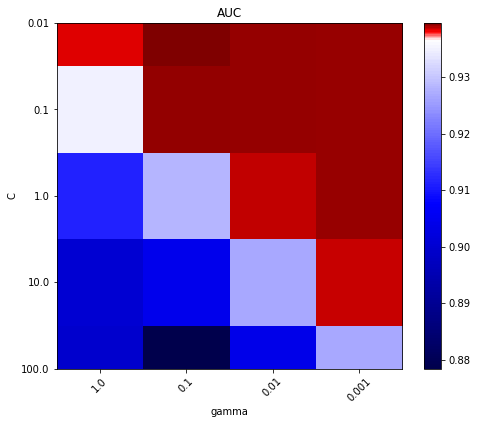

In [16]:
offset = 0.01
bla = np.arange(100, 500, 100).tolist()
# print(bla)
print(Cs)
print(gammas)
scores = grid.cv_results_['mean_test_score'].reshape(len(Cs),len(gammas))
print(scores)
plot_heatmap(scores, 'AUC', 'gamma', 'C', 
              gammas, Cs, np.min(scores), np.median(scores))


In [17]:
%%time
train_size = 8000
# tekur um 1min+ med 5 þúsund train size
X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, train_size)
X_train_reduced, vectorizer = vectorize_data(X_train_reduced)
parameters = {
    'estimator__C': 0.001* np.power(10,np.arange(5))
}
clf = OneVsRestClassifier(SVC( kernel = 'linear', class_weight = 'balanced'))
grid = GridSearchCV(clf, parameters, verbose=1, n_jobs=-1, scoring = 'roc_auc') #n_jobs=-1 notar alla kjarna
grid.fit(X_train_reduced, y_train_reduced)
print("Optimal parameters for the grid are {}s with a score of {:.2%}".format(grid.best_params_, grid.best_score_))

Data subsampling succsessful!
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.3min finished


Optimal parameters for the grid are {'estimator__C': 0.001}s with a score of 94.24%
CPU times: user 58.7 s, sys: 610 ms, total: 59.3 s
Wall time: 3min 17s


[0.94239071 0.94075508 0.93565973 0.90597291 0.84633971]


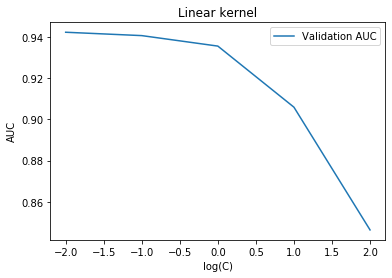

In [18]:
# plot_acc_params(Cs, , accs['val_acc']['linear'], 'C', 'Linear kernel')
scores = grid.cv_results_['mean_test_score']
print(scores)
plot_acc_params(np.log10(Cs), scores, scores, 'log(C)', 'Linear kernel')

For rbf kernal
Optimal combination is,  C: 1.0, gamma: 0.001
Giving the validation AUC: 89.53%
For linear kernal
Optimal C is: 0.01
Giving the validation AUC: 89.17%


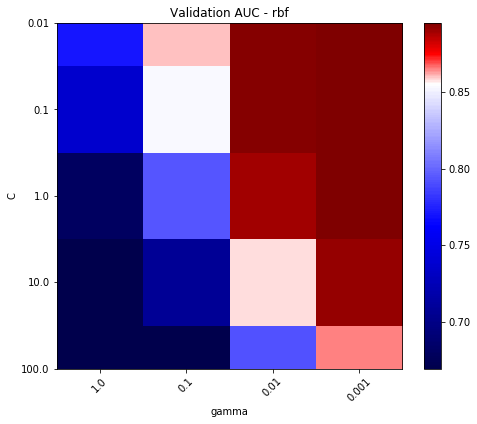

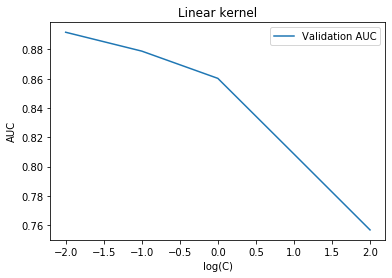

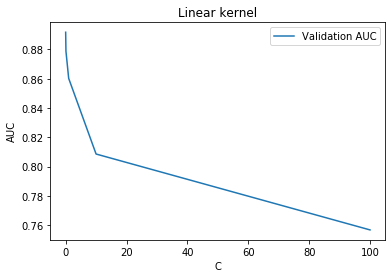

In [181]:
# rbfacc = accs['val_acc']['rbf']; linacc = accs['val_acc']['linear']
# Cind, gammaind = np.unravel_index(np.argmax(rbfacc, axis=None), rbfacc.shape)
# print('For rbf kernal')
# rbfOptparam = C[Cind], gamma[gammaind]
# print("Optimal combination is,  C: {}, gamma: {}".format(rbfOptparam[0], rbfOptparam[1]))
# print("Giving the validation AUC: {:.2%}".format(rbfacc[Cind, gammaind]))

# linearOptC = C[np.argmax(linacc)]
# print('For linear kernal')
# print("Optimal C is: {}".format(linearOptC))
# print("Giving the validation AUC: {:.2%}".format(linacc[Cindex]))

# plot_heatmap(rbfacc, 'Validation AUC - rbf', 'gamma', 'C', gamma, C,
#              np.min(rbfacc) , np.median(rbfacc))
# plot_acc_params(np.log10(C), accs['train_acc']['linear'], accs['val_acc']['linear'], 'log(C)', 'Linear kernel')
# plot_acc_params(C, accs['train_acc']['linear'], accs['val_acc']['linear'], 'C', 'Linear kernel')


Training size 15000
Using optimal C: 0.001
Data subsampling succsessful!
Test accuracy on linear kernel 48.79%
micro-averaged scores over all classes
F1 score: 0.149, 
AUC score: 0.759
--------------------
macro-averaged scores over all classes
F1 score: 0.225, 
AUC score: 0.938
--------------------


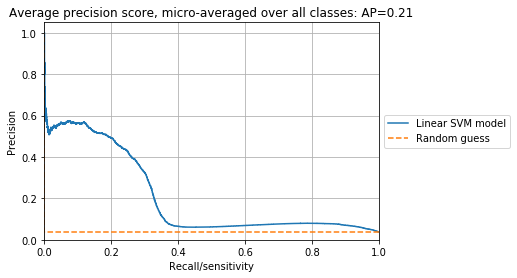

--------------------------------------------------
TN: 159343	 FP: 24950 
FN: 4603	 TP: 2594
The micro averaged sensitivity/recall is: 36.04%
The micro averaged specificity is: 86.46%
The micro averaged precision is: 9.42%
--------------------------------------------------


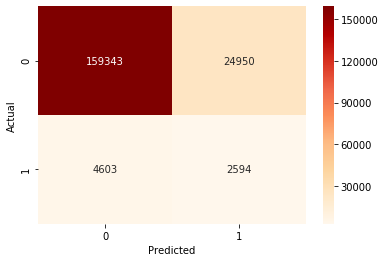

--------------------------------------------------
The macro averaged sensitivity/recall is: 52.69%
The macro averaged specificity is: 86.55%
The macro averaged precision is: 40.83%
--------------------------------------------------


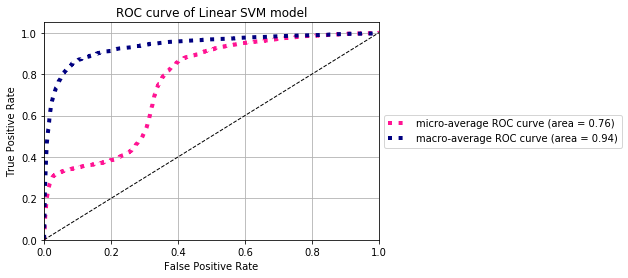

CPU times: user 17min 16s, sys: 5.22 s, total: 17min 22s
Wall time: 17min 16s


In [186]:
%%time
# TRAIN Linear Model
# Tekur ca 8min að keyra á 50þus train size
# Tekur ca 2min að keyra á 15þus train size
linearOptC =0.001
train_size = 15000
print('Training size', train_size)
print('Using optimal C: {}'.format(linearOptC))

X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, train_size)
X_train_reduced, vectorizer = vectorize_data(X_train_reduced)

x_test_unrvld = vectorizer.transform(X_test_np.ravel())
clf = OneVsRestClassifier(SVC(C = linearOptC, kernel = 'linear', class_weight = 'balanced'))
clf.fit(X_train_reduced, y_train_reduced)

y_pred_linear = clf.predict(vectorizer.transform(X_test_np.ravel()))
test_acc = get_row_accuracy(y_test_np, y_pred_linear)

print('Test accuracy on linear kernel {:.2%}'.format(test_acc))
y_scores_linear = clf.decision_function(vectorizer.transform(X_test_np.ravel()))

plot_prec_recall(y_test_np, y_scores_linear, y_pred_linear, label_='Linear SVM model')
totals_mat = confusion_matrix(y_test_np.ravel(), y_pred_linear.ravel())
plot_conf_mat(totals_mat)
calc_scores(y_test_np, y_pred_linear)

plot_roc_curve(y_test_np, y_scores_linear, show_all_classes = False, model_name = 'Linear SVM')


In [184]:
svms = clf.estimators_
mydict = vectorizer.vocabulary_
print("Most important features of Linear kernel SVM classifier")
n,m = 4, 6
mm = np.zeros((n,m))
for i in range(len(class_names)):
    coefs = svms[i].coef_
    co = np.zeros(coefs.shape[1])
    for j in range(coefs.shape[1]):
        co[j] = abs(coefs[0,j])
    mm[:,i] = co.argsort()[-n:][::-1]

mydict = vectorizer.vocabulary_
for i in range(m):
    print("Most important features for class {}".format(class_names[i]))
    for k in mm[:,i]:
        print("\t", list(mydict.keys())[list(mydict.values()).index(k)])

Most important features of Linear kernel SVM classifier
Most important features for class toxic
	 fuck
	 bitch
	 shit
	 fucking
Most important features for class severe_toxic
	 fuck
	 suck
	 bitch
	 dick
Most important features for class obscene
	 fuck
	 bitch
	 shit
	 fucking
Most important features for class threat
	 ass
	 fuck
	 kill
	 suck
Most important features for class insult
	 fuck
	 bitch
	 suck
	 asshole
Most important features for class identity_hate
	 gay
	 hate
	 suck
	 shit


In [181]:
print(X_test_np.shape)
bla = [sc]
test_sent = vectorizer.transform(bla)[0]
pre = clf.predict(test_sent)[0]
bre = np.where(pre==1)[0]
print(bla[0])
print("Classified as:\n",np.array(class_names)[bre])
print(pre)


(31915, 1)
My buddy is gay, he has a black cat. He plays yatzee with a die.
Classified as:
 ['toxic' 'severe_toxic' 'obscene']
[1 1 1 0 0 0]


micro-averaged scores over all classes
F1 score: 0.501, 
AUC score: 0.931
--------------------
macro-averaged scores over all classes
F1 score: 0.421, 
AUC score: 0.946
--------------------


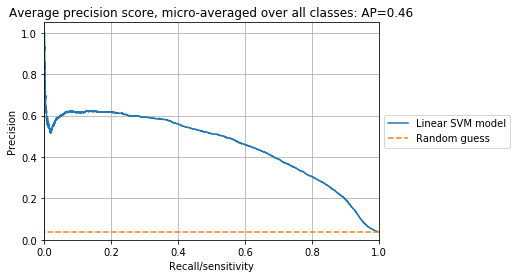

--------------------------------------------------
TN: 176523	 FP: 7770 
FN: 2189	 TP: 5008
The micro averaged sensitivity/recall is: 69.58%
The micro averaged specificity is: 95.78%
The micro averaged precision is: 39.19%
--------------------------------------------------


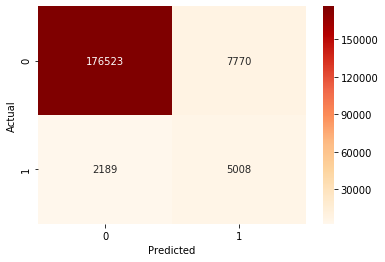

--------------------------------------------------
The macro averaged sensitivity/recall is: 75.23%
The macro averaged specificity is: 95.83%
The macro averaged precision is: 36.81%
--------------------------------------------------


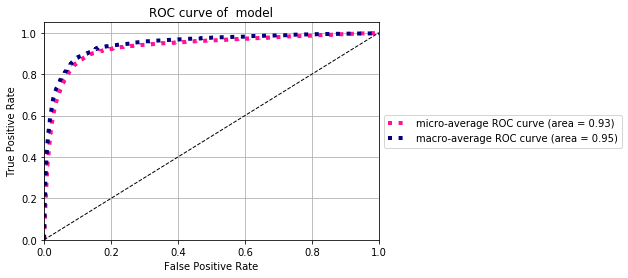

In [88]:
# Nota þetta til að prufa gröf betur
plot_prec_recall(y_test_np, y_scores_linear, y_pred_linear, label_='Linear SVM model')
totals_mat = confusion_matrix(y_test_np.ravel(), y_pred_linear.ravel())
plot_conf_mat(totals_mat)
calc_scores(y_test_np, y_pred_linear)
plot_roc_curve(y_test_np, y_scores_linear, show_all_classes = False)



Training size 15000
Using optimal C: 0.01 and gamma: 0.1
Test accuracy on rbf kernel 10.07%
micro-averaged scores over all classes
F1 score: 0.206, 
AUC score: 0.826
--------------------
macro-averaged scores over all classes
F1 score: 0.268, 
AUC score: 0.917
--------------------


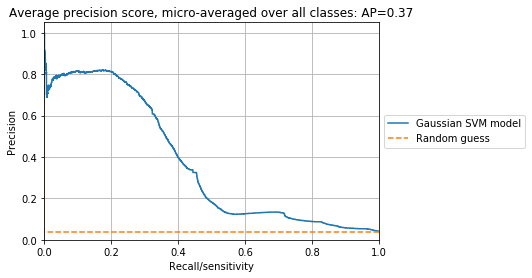

--------------------------------------------------
TN: 156872	 FP: 27421 
FN: 3212	 TP: 3985
The micro averaged sensitivity/recall is: 55.37%
The micro averaged specificity is: 85.12%
The micro averaged precision is: 12.69%
--------------------------------------------------


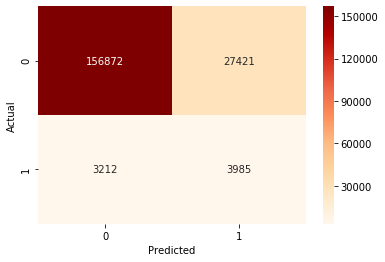

--------------------------------------------------
The macro averaged sensitivity/recall is: 38.48%
The macro averaged specificity is: 84.15%
The macro averaged precision is: 43.90%
--------------------------------------------------


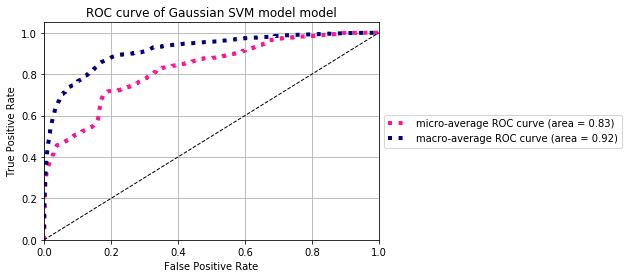

CPU times: user 18min 43s, sys: 4.68 s, total: 18min 48s
Wall time: 18min 39s


In [187]:
%%time
# TRAIN Gaussina SVM

# Tekur ca 8min að keyra á 50þus train size
# Tekur ca 2min að keyra á 15þus train size
rbfOptparam = 0.01, 0.1
print('Training size', train_size)
print('Using optimal C: {} and gamma: {}'.format(rbfOptparam[0], rbfOptparam[1]))

x_test_unrvld = vectorizer.transform(X_test_np.ravel())
clfrbf = OneVsRestClassifier(SVC(C = rbfOptparam[0], gamma = rbfOptparam[1],
                              kernel = 'rbf', class_weight = 'balanced') )
clfrbf.fit(X_train_reduced, y_train_reduced)

y_pred_rbf = clfrbf.predict(vectorizer.transform(X_test_np.ravel()))

test_acc = get_row_accuracy(y_test_np, y_pred_rbf)

print('Test accuracy on rbf kernel {:.2%}'.format(test_acc))

y_scores_rbf = clfrbf.decision_function(vectorizer.transform(X_test_np.ravel()))

plot_prec_recall(y_test_np, y_scores_rbf, y_pred_rbf, label_='Gaussian SVM model')

totals_mat = confusion_matrix(y_test_np.ravel(), y_pred_rbf.ravel())
plot_conf_mat(totals_mat)
calc_scores(y_test_np, y_pred_rbf)

plot_roc_curve(y_test_np, y_scores_rbf, show_all_classes = False, model_name = 'Gaussian SVM model')

In [182]:
print(X_test_np.shape)
bla = ["My buddy is gay, he has a black cat. He plays yatzee with a die."]
test_sent = vectorizer.transform(bla)[0]
pre = clfrbf.predict(test_sent)[0]
bre = np.where(pre==1)[0]
print(bla[0])
print("Classified as:\n",np.array(class_names)[bre])
print(pre)


(31915, 1)
My buddy is gay, he has a black cat. He plays yatzee with a die.
Classified as:
 ['threat' 'insult' 'identity_hate']
[0 0 0 1 1 1]


--------------------------------------------------
TN: 183400	 FP: 893 
FN: 3552	 TP: 3645
The micro averaged sensitivity/recall is: 50.65%
The micro averaged specificity is: 99.52%
The micro averaged precision is: 80.32%
--------------------------------------------------


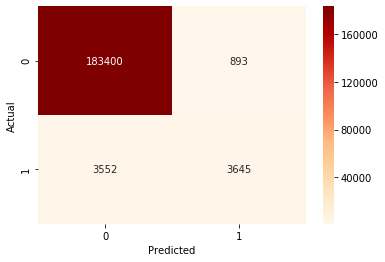

--------------------------------------------------
The macro averaged sensitivity/recall is: 30.30%
The macro averaged specificity is: 99.50%
The macro averaged precision is: 51.65%
--------------------------------------------------


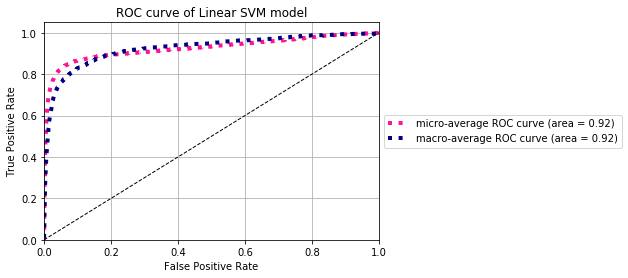

--------------------------------------------------
TN: 183184	 FP: 1109 
FN: 3100	 TP: 4097
The micro averaged sensitivity/recall is: 56.93%
The micro averaged specificity is: 99.40%
The micro averaged precision is: 78.70%
--------------------------------------------------


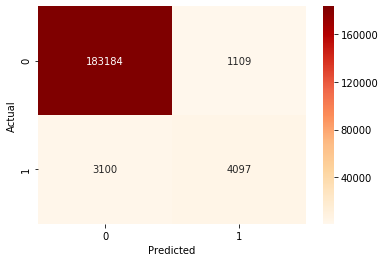

--------------------------------------------------
The macro averaged sensitivity/recall is: 33.82%
The macro averaged specificity is: 99.38%
The macro averaged precision is: 65.91%
--------------------------------------------------


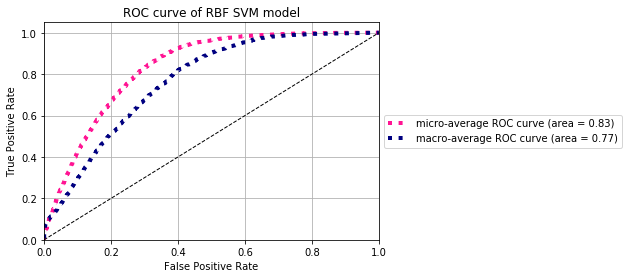

In [77]:
totals_mat = confusion_matrix(y_test_np.ravel(), y_pred_linear.ravel())
plot_conf_mat(totals_mat)
calc_scores(y_test_np, y_pred_linear)
plot_roc_curve(y_test_np, y_scores_linear, show_all_classes = False, model_name = 'Linear SVM')



totals_mat = confusion_matrix(y_test_np.ravel(), y_pred_rbf.ravel())
plot_conf_mat(totals_mat)
calc_scores(y_test_np, y_pred_rbf)
plot_roc_curve(y_test_np, y_scores_rf, show_all_classes = False, model_name = 'RBF SVM')






### Random forrest


Start by finding a optimal number of trees for default values of the random forrest

Data subsampling succsessful!


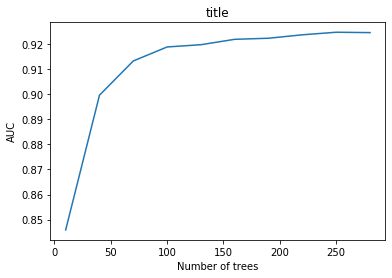

Number of trees for highest AUC 250
CPU times: user 11min 22s, sys: 9.11 s, total: 11min 31s
Wall time: 2min 12s


In [171]:
%%time
train_size = 15000
#tekur um 1min20 sec með 50þús train size
X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, train_size)
X_train_reduced, vectorizer = vectorize_data(X_train_reduced)

# Use our best RF model 
auc_scores = []; acc_rf = []
param = np.arange(10, 300, 30).tolist()

for i in param:

    rf = RandomForestClassifier(n_estimators=i, class_weight = 'balanced', n_jobs = -1)
    rf.fit(X_train_reduced, y_train_reduced)
    y_pred_ = rf.predict(vectorizer.transform(X_test_np.ravel()))
    test_acc = get_row_accuracy(y_test_np, y_pred_)
    acc_rf.append(test_acc)
    
    y_proba = rf.predict_proba(vectorizer.transform(X_test_np.ravel()) )
    y_scores_rf = np.zeros(y_test_np.shape)
    for i in range(len(y_proba)):
        y_scores_rf[:,i] = y_proba[i][:,1]
    auc = roc_auc_score(y_test_np, y_scores_rf, average = 'macro')
    auc_scores.append(auc)
    
plt.plot(param, auc_scores,label='AUC ')
plt.xlabel('Number of trees')
plt.ylabel("AUC")
plt.show()
m =np.argmax(auc_scores)
print('Number of trees for highest AUC', param[m])

In [57]:
%%time
warnings.filterwarnings("ignore") # ignore warnings for the purpose of readability

train_size = 5000
# tekur um 1min+ med 5 þúsund train size
X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, train_size)
X_train_reduced, vectorizer = vectorize_data(X_train_reduced)
depth_range = np.arange(120, 350, 50).tolist()
# depth_range.insert(0,100)

features_range = np.arange(5, 30, 10).tolist()
features_range.append('sqrt')
features_range.append(90)

# features_range.insert(0,10)



parameters = {
    'max_depth': depth_range,
    'max_features': features_range
}
rf = RandomForestClassifier(n_estimators=100, oob_score=False, class_weight = 'balanced')
grid = GridSearchCV(rf, parameters, verbose=1, n_jobs=-1, scoring = 'roc_auc') #n_jobs=-1 notar alla kjarna
grid.fit(X_train_reduced, y_train_reduced)
print("Optimal parameters for the grid are {}s with a score of {:.2%}".format(grid.best_params_, grid.best_score_))

Data subsampling succsessful!
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  1.1min finished


Optimal parameters for the grid are {'max_depth': 120, 'max_features': 'sqrt'}s with a score of 74.26%
CPU times: user 2.69 s, sys: 62.8 ms, total: 2.75 s
Wall time: 1min 7s


[120, 170, 220, 270, 320]
[5, 15, 25, 'sqrt', 90]
[[0.73130059 0.73855553 0.7369369  0.74259156 0.73289169]
 [0.738611   0.74067681 0.70704749 0.73041484 0.72719486]
 [0.73438439 0.73513181 0.72303815 0.73425459 0.71212387]
 [0.7264216  0.73520396 0.72139681 0.72050724 0.73002261]
 [0.72986732 0.72583695 0.73700749 0.73683937 0.71137787]]


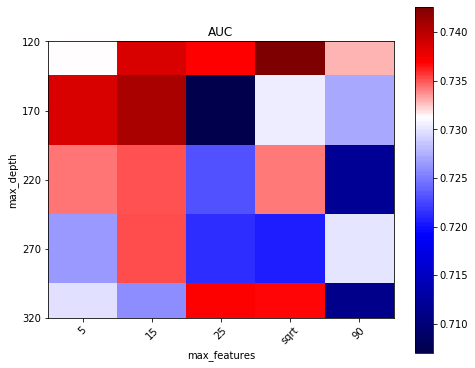

In [58]:
# print(grid.cv_results_)
# print(grid.cv_results_['mean_test_score'])
# sama mynd og að ofan, betra að stilla hér
offset = 0.01
bla = np.arange(100, 500, 100).tolist()
# print(bla)
print(depth_range)
print(features_range)
scores = grid.cv_results_['mean_test_score'].reshape(len(depth_range),len(features_range))
print(scores)
plot_heatmap(scores, 'AUC', 'max_features', 'max_depth', 
              features_range, depth_range, np.min(scores), np.median(scores))


Data subsampling succsessful!
Training size:  50000
Using max depth: 120 and max features: sqrt


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


Test acc 47.69%


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.7s finished


micro-averaged scores over all classes
F1 score: 0.144, 
AUC score: 0.767
--------------------
macro-averaged scores over all classes
F1 score: 0.109, 
AUC score: 0.649
--------------------


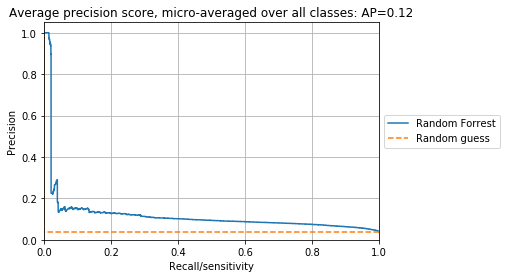

--------------------------------------------------
TN: 125441	 FP: 58852 
FN: 2057	 TP: 5140
The micro averaged sensitivity/recall is: 71.42%
The micro averaged specificity is: 68.07%
The micro averaged precision is: 8.03%
--------------------------------------------------


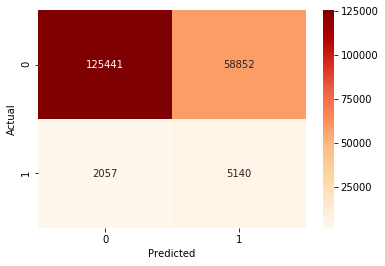

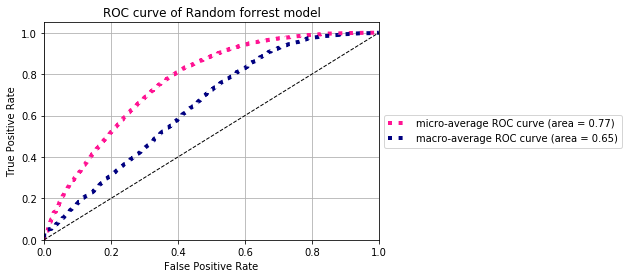

--------------------------------------------------
The macro averaged sensitivity/recall is: 49.25%
The macro averaged specificity is: 67.60%
The macro averaged precision is: 9.26%
--------------------------------------------------
CPU times: user 2min 44s, sys: 2.52 s, total: 2min 46s
Wall time: 32.2 s


In [106]:
%%time
train_size = 50000
#tekur um 1min20 sec með 50þús train size
X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, train_size)
X_train_reduced, vectorizer = vectorize_data(X_train_reduced)

# Fit and test it
# best_max_depth=grid.best_params_['max_depth']
# best_max_features=grid.best_params_['max_features']
best_max_depth = 120
best_max_features = 'sqrt'
# Use our best RF model 
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=best_max_depth,
    max_features=best_max_features,
    oob_score=False,
    class_weight = 'balanced',
    n_jobs = -1,
    verbose = 1
)
print('Training size: ', train_size)
print('Using max depth: {} and max features: {}'.format(best_max_depth, best_max_features))
rf.fit(X_train_reduced, y_train_reduced)
y_pred_rf = rf.predict(vectorizer.transform(X_test_np.ravel()))

test_acc = get_row_accuracy(y_test_np, y_pred_rf)
print('Test acc {:.2%}'.format(test_acc))

y_proba = rf.predict_proba(vectorizer.transform(X_test_np.ravel()) )
y_scores_rf = np.zeros(y_test_np.shape)

for i in range(len(y_proba)):
    y_scores_rf[:,i] = y_proba[i][:,1]
    

plot_prec_recall(y_test_np, y_scores_rf, y_pred_rf, label_='Random Forrest')

totals_mat = confusion_matrix(y_test_np.ravel(), y_pred_rf.ravel())
plot_conf_mat(totals_mat)
plot_roc_curve(y_test_np, y_scores_rf, show_all_classes = False, model_name = 'Random forrest')
calc_scores(y_test_np, y_pred_rf)


In [197]:
bla = ["My good friend, who is a muslim, has ablack cat."]
test_sent = vectorizer.transform(bla)[0]
pre = rf.predict(test_sent)[0]
bre = np.where(pre==1)[0]
print(bla[0])
print("Classified with random forrest as:\n",np.array(class_names)[bre])
print(pre)

ValueError: Number of features of the model must match the input. Model n_features is 11020 and input n_features is 5073 

In [131]:
print(rf.feature_importances_.shape)
m = np.argmax(rf.feature_importances_)
mm = rf.feature_importances_.argsort()[-10:][::-1]
print(mm)
mydict = vectorizer.vocabulary_
print("Most important features of random forrest classifier")
for m in mm:
    print(list(mydict.keys())[list(mydict.values()).index(m)])

(11020,)
[3970 4348 6757 4428 4354 5686 4941 8982 9576 9530]
Most important features of random forrest classifier
faggot
fuck
nigger
gay
fucking
kill
hope
shit
suck
stupid


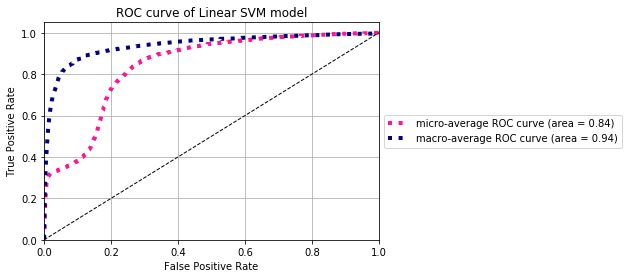

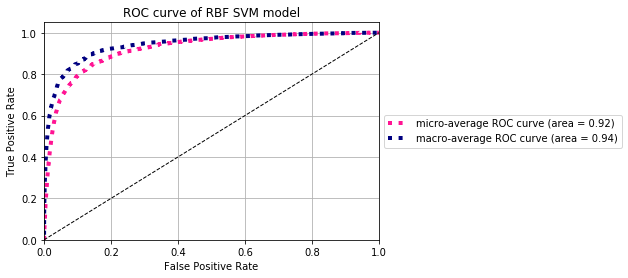

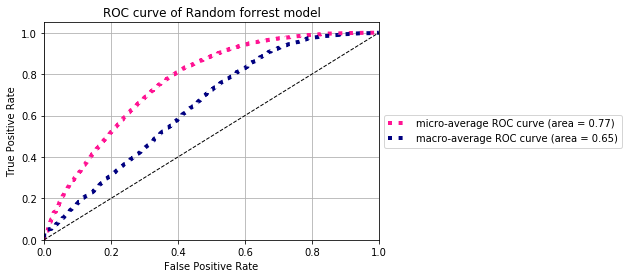

In [108]:
plot_roc_curve(y_test_np, y_scores_linear, show_all_classes = False, model_name = 'Linear SVM')
plot_roc_curve(y_test_np, y_scores_rbf, show_all_classes = False, model_name = 'RBF SVM')
plot_roc_curve(y_test_np, y_scores_rf, show_all_classes = False, model_name = 'Random forrest')
